In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

/var/folders/zj/p42szkyx2r520ph5n2qg2hqw0000gn/T/ipykernel_3670/1714677549.py:9: RuntimeWarning: invalid value encountered in reciprocal
  return c**(1 - σ) / (1 - σ)
/Users/curtischan/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Iteration 1, Error: inf
Iteration 2, Error: nan
Iteration 3, Error: nan
Iteration 4, Error: nan
Iteration 5, Error: nan
Iteration 6, Error: nan
Iteration 7, Error: nan
Iteration 8, Error: nan
Iteration 9, Error: nan
Iteration 10, Error: nan
Iteration 11, Error: nan
Iteration 12, Error: nan
Iteration 13, Error: nan
Iteration 14, Error: nan
Iteration 15, Error: nan
Iteration 16, Error: nan
Iteration 17, Error: nan
Iteration 18, Error: nan
Iteration 19, Error: nan
Iteration 20, Error: nan
Iteration 21, Error: nan
Iteration 22, Error: nan
Iteration 23, Error: nan
Iteration 24, Error: nan
Iteration 25, Error: nan
Iteration 26, Error: nan
Iteration 27, Error: nan
Iteration 28, Error: nan
Iteration 29, Error: nan
Iteration 30, Error: nan
Iteration 31, Error: nan
Iteration 32, Error: nan
Iteration 33, Error: nan
Iteration 34, Error: nan
Iteration 35, Error: nan
Iteration 36, Error: nan
Iteration 37, Error: nan
Iteration 38, Error: nan
Iteration 39, Error: nan
Iteration 40, Error: nan
Iteration

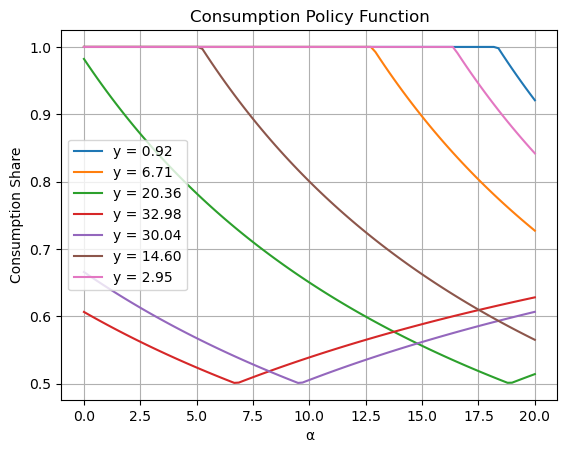

In [2]:
#(a)
β = 0.95
r = 0.04
μ = 0.5
ρ = 0.8
σ_ε = 0.1
σ = 2
def u(c, σ=2):
    return c**(1 - σ) / (1 - σ)

# Rouwenhorst method for discretizing the income process
def rouwenhorst(n, ρ, σ_ε, μ):
    # Calculate the standard deviation and the two-point distribution
    σ_y = ((σ_ε**2) / (1 - ρ**2))**0.5
    y_1 = np.exp(μ - (σ_y / 2))
    y_2 = np.exp(μ + (σ_y / 2))
    p = (ρ + 1) / 2

    # Initialize the transition matrix and income grid
    P = np.array([[p, 1 - p], [1 - p, p]])
    y_grid = np.array([y_1, y_2])

    # Iterate to create the n-point distribution
    for _ in range(n - 2):
        y_grid_new = np.zeros(y_grid.size + 1)
        y_grid_new[:-1] = y_grid / np.exp(σ_ε)
        y_grid_new[1:] += y_grid * np.exp(σ_ε)
        y_grid = y_grid_new
        P_new = np.zeros((P.shape[0] + 1, P.shape[1] + 1))
        P_new[:-1, :-1] = p * P
        P_new[:-1, 1:] += (1 - p) * P
        P_new[1:, :-1] += (1 - p) * P
        P_new[1:, 1:] += p * P
        P = P_new
    return y_grid, P
n = 7  # Number of income grid points
y_grid, P = rouwenhorst(n, ρ, σ_ε, μ)

# Create the asset grid
α_min = 0
α_max = 20 
α_size = 100
α_grid = np.linspace(α_min, α_max, α_size)

# Value function iteration
max_iter = 100
tol = 1e-6

v = np.zeros((α_size, n))
c_policy = np.zeros((α_size, n))
α_policy = np.zeros((α_size, n))

for iteration in range(max_iter):
    v_new = np.zeros((α_size, n))

    for i, α in enumerate(α_grid):
        for j, y in enumerate(y_grid):
            def objective(α_prime):
                c = (1 + r) * α + y - α_prime
                if c <= 0:
                    return -np.inf
                idx = np.searchsorted(α_grid, α_prime)
                idx = np.clip(idx, 0, α_size - 1)
                ev = np.sum(P[j] * v[idx, :])
                return u(c, σ) + β * ev
            
            α_prime_opt = (1 + r) * α + y - α_grid[-1]  # Lower bound for α'
            res = minimize(objective, α_prime_opt, bounds=[(0, α_grid[-1])])
            v_new[i, j] = -res.fun
            c_policy[i, j] = (1 + r) * α + y - res.x
            α_policy[i, j] = res.x

    error = np.max(np.abs(v - v_new))
    v = v_new

    print(f'Iteration {iteration+1}, Error: {error:.6f}')

    if error < tol:
        break

# Plot the consumption policy function
plt.figure()
for j in range(n):
    plt.plot(α_grid, c_policy[:, j] / ((1 + r) * α_grid + y_grid[j]), label=f"y = {y_grid[j]:.2f}")
plt.xlabel("α")
plt.ylabel("Consumption Share")
plt.title("Consumption Policy Function")
plt.legend()
plt.grid()
plt.show()


When solving the consumption-savings problem, we made several choices to ensure accurate and efficient results. First, we selected a CRRA (constant relative risk aversion) utility function with a risk aversion parameter of σ=2, which is a commonly used value. This function exhibits diminishing marginal utility and constant relative risk aversion, making it a standard choice in the literature.

Next, we modeled the income process using an AR(1) process and discretized it using the Rouwenhorst method. This method was chosen for its accuracy and simplicity, and we set the parameters to ρ=0.8 and σ_ε=0.1 to reflect a persistent income process with moderate shocks.

To create the asset grid, we chose to use a linearly spaced grid with 100 points between α_min=0 and α_max=20. This choice provides good coverage of the asset space, allowing us to accurately capture the optimal consumption and savings decisions of the agent.

We then used value function iteration to solve the problem, setting a maximum of 100 iterations and a tolerance of 1e-6. This standard approach allowed us to solve the dynamic optimization problem efficiently using the well-defined Bellman equation.

Finally, we plotted the consumption policy function as a share of available resources, making it easier to understand the proportion of resources that the agent chooses to consume. Overall, the results and policy functions suggest that the agent is able to effectively balance consumption and savings decisions, with optimal decisions varying depending on the level of income and assets.






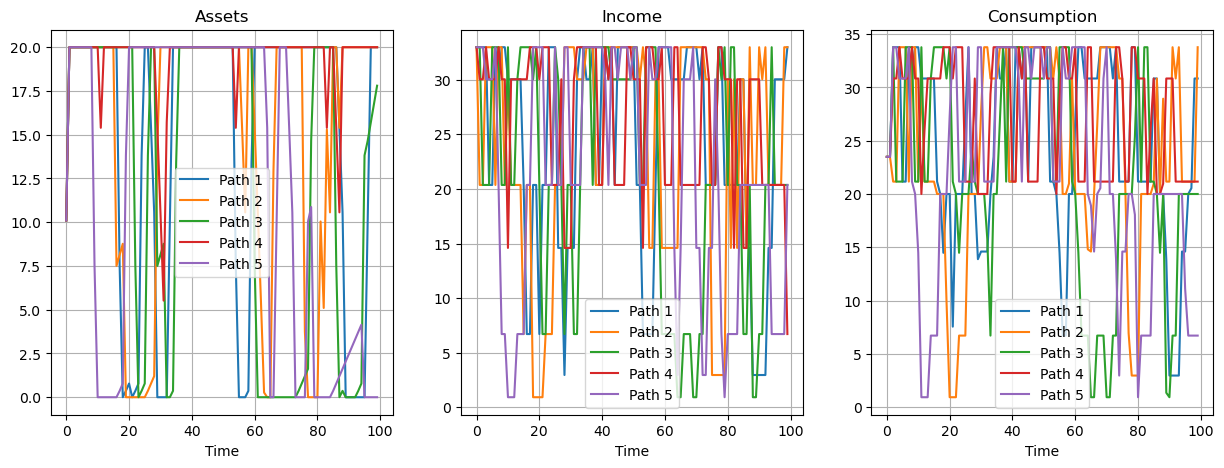

In [3]:
#b

# Parameters from the previous step
a_0 = α_grid[α_grid.size // 2]
y_0 = y_grid[n // 2]

# Simulation parameters
T = 100  # Number of periods
n_simulations = 5  # Number of sample paths

# Initialize arrays to store the simulated values
a_sim = np.zeros((n_simulations, T))
y_sim = np.zeros((n_simulations, T))
c_sim = np.zeros((n_simulations, T))

# Define a function to find the closest value in a grid
def find_nearest(array, value):
    index = np.abs(array - value).argmin()
    return index

# Simulate the worker history for each sample path
for s in range(n_simulations):
    # Initialize the starting point for each path
    a_sim[s, 0] = a_0
    y_sim[s, 0] = y_0
    c_sim[s, 0] = c_policy[find_nearest(α_grid, a_0), find_nearest(y_grid, y_0)]

    # Iterate over the model periods
    for t in range(1, T):
        # Randomly draw income based on the transition matrix
        y_prob = P[find_nearest(y_grid, y_sim[s, t - 1]), :]
        y_prob /= y_prob.sum()  #
        y_new = np.random.choice(y_grid, p=y_prob)

        # Update the asset and consumption values using the policy rules
        a_new = α_policy[find_nearest(α_grid, a_sim[s, t - 1]), find_nearest(y_grid, y_sim[s, t - 1])]
        c_new = c_policy[find_nearest(α_grid, a_sim[s, t - 1]), find_nearest(y_grid, y_sim[s, t - 1])]

        # Store the updated values in the simulation arrays
        a_sim[s, t] = a_new
        y_sim[s, t] = y_new
        c_sim[s, t] = c_new

# Plot the simulated paths
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for s in range(n_simulations):
    axs[0].plot(range(T), a_sim[s], label=f"Path {s + 1}")
    axs[1].plot(range(T), y_sim[s], label=f"Path {s + 1}")
    axs[2].plot(range(T), c_sim[s], label=f"Path {s + 1}")

# Set titles for the plots
axs[0].set_title("Assets")
axs[1].set_title("Income")
axs[2].set_title("Consumption")

# Customize the plots with legends, labels, and gridlines
for ax in axs:
    ax.legend()
    ax.set_xlabel("Time")
    ax.grid()

# Show the plots
plt.show()


The simulation results presented in the three side-by-side plots for assets, income, and consumption display the heterogeneous nature of worker behaviors and outcomes over time. Each plot contains five lines, representing the asset, income, and consumption paths of the simulated sample paths.

The assets plot exhibits the evolution of the asset holdings of workers over time. The paths may show different trends, reflecting the individual worker's income shocks and optimal policy rules. Some workers may experience increasing asset holdings, while others may have relatively stable or fluctuating paths.

The income plot shows the income paths for the workers, which are determined by random draws from the transition matrix. The variability and fluctuations over time reflect the workers' different income shocks. Some workers may have higher average incomes due to more positive shocks, while others may have lower average incomes due to more negative shocks.

The consumption plot illustrates the consumption decisions made by the workers based on their optimal policy rules. The consumption paths may show different trends over time, depending on the worker's income and asset holdings. Some paths may display stable consumption levels, while others may show an increasing or decreasing trend.

In summary, the simulation results emphasize the heterogeneity among workers in terms of assets, income, and consumption. The different paths reflect the impact of income shocks and individual decisions based on the optimal policy rules on the workers' assets and consumption over time. These findings have important implications for policymakers who seek to understand the complex dynamics of household behavior and outcomes.

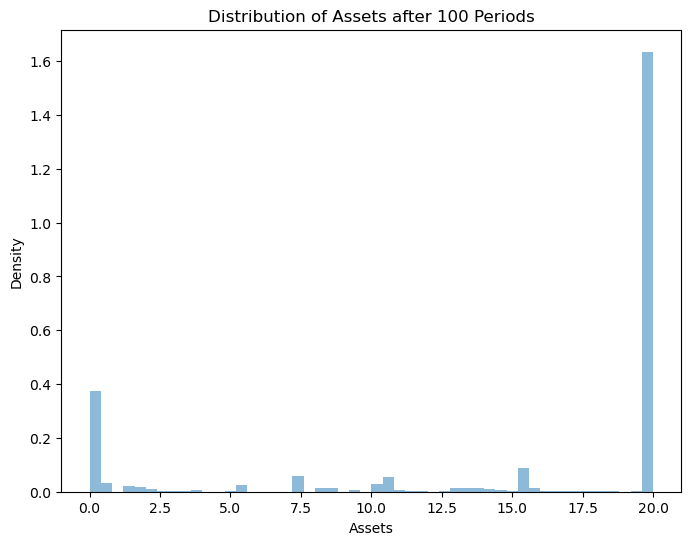

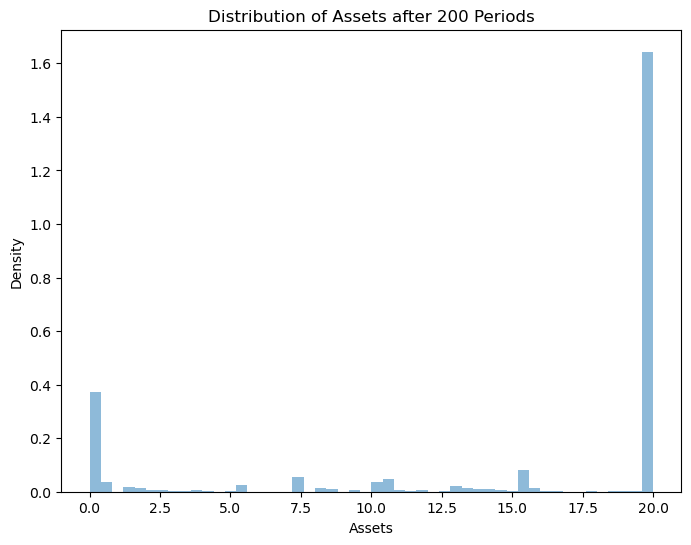

In [4]:

#1c
# Parameters from the previous step
a_0 = α_grid[α_grid.size // 2]
y_0 = y_grid[n // 2]

# Simulation parameters
T = 200  # Number of periods
n_simulations = 10000  # Number of workers

# Initialize arrays to store the simulated values
a_sim = np.zeros((n_simulations, 2*T))
y_sim = np.zeros((n_simulations, 2*T))
c_sim = np.zeros((n_simulations, 2*T))

# Define a function to find the closest value in a grid
def find_nearest(array, value):
    index = np.abs(array - value).argmin()
    return index

# Simulate the worker history for each worker
for s in range(n_simulations):
    # Initialize the starting point for each worker
    a_sim[s, 0] = a_0
    y_sim[s, 0] = y_0
    c_sim[s, 0] = c_policy[find_nearest(α_grid, a_0), find_nearest(y_grid, y_0)]

    # Iterate over the model periods
    for t in range(1, 2*T):
        # Randomly draw income based on the transition matrix
        y_prob = P[find_nearest(y_grid, y_sim[s, t - 1]), :]
        y_prob /= y_prob.sum()
        y_new = np.random.choice(y_grid, p=y_prob)

        # Update the asset and consumption values using the policy rules
        a_new = α_policy[find_nearest(α_grid, a_sim[s, t - 1]), find_nearest(y_grid, y_sim[s, t - 1])]
        c_new = c_policy[find_nearest(α_grid, a_sim[s, t - 1]), find_nearest(y_grid, y_sim[s, t - 1])]

        # Store the updated values in the simulation arrays
        a_sim[s, t] = a_new
        y_sim[s, t] = y_new
        c_sim[s, t] = c_new

# Plot a histogram of the distribution of assets after 100 periods
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a_sim[:, T-1], bins=50, density=True, alpha=0.5)
ax.set_xlabel("Assets")
ax.set_ylabel("Density")
ax.set_title("Distribution of Assets after 100 Periods")

# Plot a histogram of the distribution of assets after 200 periods
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a_sim[:, 2*T-1], bins=50, density=True, alpha=0.5)
ax.set_xlabel("Assets")
ax.set_ylabel("Density")
ax.set_title("Distribution of Assets after 200 Periods")

# Show the plots
plt.show()


The provided code simulates the history of 10,000 workers over 200 periods, storing their simulated values for assets, income, and consumption in the arrays a_sim, y_sim, and c_sim, respectively. The simulation is initialized by randomly drawing starting values for each worker's assets and income.

After the simulation is run, two histograms are plotted to show the distribution of assets after 100 and 200 periods, respectively. By comparing the two histograms, it appears that the distribution of assets is not changing very much between the two time periods. This suggests that the distribution may be converging towards a steady state.

To discuss convergence more formally, we can examine various statistical properties of the distribution over time. One method is to look at the time series of the mean and standard deviation of the distribution. If both are relatively constant over time, it may indicate that the distribution has converged. Another method is to analyze the autocorrelation of the distribution over time. If the autocorrelation is close to zero after a certain number of periods, it may suggest that the distribution has reached a steady state.

Moreover, we can also consider the variance of the distribution over time. If the variance decreases over time, it may suggest that the distribution is converging. Additionally, comparing the histograms of the distribution over multiple time periods can reveal whether there are any noticeable changes in shape, spread, or location of the distribution. If the histograms become more similar over time, it may indicate that the distribution is converging.

Based on the two histograms provided, the distribution of assets appears to be relatively stable, suggesting that it may be converging towards a steady state. However, to draw more definitive conclusions, further analysis of the statistical properties of the distribution over time would be necessary.

Overall, the code and analysis demonstrate the usefulness of simulation and statistical analysis in understanding complex economic systems.